In [1]:
import multiprocessing
import pickle
import itertools
import math
from multiprocessing import Pool, TimeoutError
from functools import partial

# External libraries
import numpy as np
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.models.word2vec import LineSentence
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import sklearn.metrics
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn import model_selection, metrics

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import Callback

Using TensorFlow backend.


## Create a list of lists of words (sentence)
Load training and test sentences.  
Create *training_sentences* and *test_sentences*.  
For each sentence get the corrispondent predominant class (*training_predominant_classes* and *test_predominant_classes*).

In [2]:
with open("../../build-sentences/data/first_training_set_200.pkl", "rb") as input_file:
    training_tuples = pickle.load(input_file)

with open("../../build-sentences/data/first_test_set_200.pkl", "rb") as input_file:
    test_tuples = pickle.load(input_file)
    
training_predominant_classes = [x[-1] for x in training_tuples]
test_predominant_classes = [x[-1] for x in test_tuples]

training_sentences = [x[0] for x in training_tuples]
test_sentences = [x[0] for x in test_tuples]

training_sentences_splitted = [x.split(' ') for x in training_sentences]
test_sentences_splitted = [x.split(' ') for x in test_sentences]    

print("Length of the training_sentences: ", len(training_sentences_splitted))
print("Length of the test_sentences: ", len(test_sentences_splitted))

print("Example:\n")
print(training_sentences_splitted[5])

Length of the training_sentences:  1082
Length of the test_sentences:  418
Example:

['Food', 'Food', 'Arts_&_Entertainment', 'Professional_&_Other_Places', 'Travel_&_Transport', 'Travel_&_Transport', 'Arts_&_Entertainment', 'Travel_&_Transport', 'Outdoors_&_Recreation', 'Travel_&_Transport']


# Setup of the Word2Vec model

## W2V: tuning of the parameters
Question: which is the best word2vec configuration? how to choose the hyper-parameters?  
We decided to use the configuration (set of parameters) which maximize the f1-score of a 5-fold cross validation over the training set using a SVM with default parameters.

#### Helper functions

In [3]:
def create_w2v_mapper(sentences, size=50, window=10, sample=1E-3):
    params = {'sg' : 1, 'size': size, 'window': window, 'min_count': 1, 
          'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,}

    model = Word2Vec(sentences_splitted, **params)
    word_vectors = model.wv
    return dict(zip(model.wv.index2word, model.wv.syn0)), model

def convert_class_string_to_id(predominant_classes):
    mapper = {'Other': 0, 'OpenSpace': 1, 'Residential': 2,
                    'Commercial': 3, 'Transportation': 4, 'Mixed': 5}
    
    return [mapper[x] for x in predominant_classes]

def preprocess_w2v_cells(mapper, sentences_splitted):
    # this are the Xs of the SVM's input
    svm_input_vectors = []
    
    for sentence in sentences_splitted:

        # for each word inside the sentence contained in cell
        # map the word into the corresponding w2v vector
        # array where each element is the corresponding vector of a word
        cell_w2v_vectors = np.array([mapper[x] for x in sentence])

        # do the column-wise mean of this vectors
        # to abtain a single vector for the sentence (cell)
        mean_cell_vector = np.mean(cell_w2v_vectors, axis=0)

        # append the vector representing the entire cell
        # to the svm_input list
        svm_input_vectors.append(mean_cell_vector)
        
    return svm_input_vectors

def divide_sets_by_index(dataset, training_index, test_index):
    training_set = []
    test_set = []
    
    for i in range(len(dataset)):
        if i in training_index:
            training_set.append(dataset[i])
        else:
            test_set.append(dataset[i])
    
    return training_set, test_set

def get_best_combination(combination_and_scores):
    scores = [x[1] for x in combination_and_scores]
    best_index = np.argmax(scores)
    return combination_and_scores[best_index][0]

def inner_w2v_cross_process(combination_parameters, training_sentences, training_classes):
    window_size, features_size, sample = combination_parameters
    
    # Create w2v model and mapper
    cmapper, _ = create_w2v_mapper(training_sentences, window=window_size, size=features_size, sample=sample)
    
    # Mapper each sentence to a unique vector
    X_train = preprocess_w2v_cells(cmapper, training_sentences)
    y_train = training_classes

    innerf1 = []
    skf = model_selection.StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    for train_indexes, test_indexes in skf.split(X_train, y_train):
        
        X2_train, X2_test = divide_sets_by_index(X_train, train_indexes, test_indexes)
        y2_train, y2_test = divide_sets_by_index(y_train, train_indexes, test_indexes)

        sclf = SVC()
        sclf.fit(X2_train, y2_train)
        ipred = sclf.predict(X2_test)
        
        innerf1.append(metrics.f1_score(ipred, y2_test, average="macro"))
                         
    return combination_parameters, np.mean(innerf1) 

In [4]:
# Values of Windows Size (W2V)
WindowSize = [3, 5, 7, 10, 20]

# Size of the Features Vector (W2V)
FeaturesSize = [30, 50, 100, 200]

# The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5)
Samples = [1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 0]

# Get all possibile combination of WindowSize, FeaturesSize, Samples
combination_parameters = list(itertools.product(WindowSize, FeaturesSize, Samples))

# use both training and test sentences to train the word2vec model
sentences_splitted = training_sentences_splitted + test_sentences_splitted

# run in parallel cross validation
with Pool(processes=4) as pool:
    combination_and_scores = pool.map(partial(inner_w2v_cross_process,
                                              training_sentences=training_sentences_splitted,
                                              training_classes=training_predominant_classes),
                                      combination_parameters)
    
best_w2v_parameters = get_best_combination(combination_and_scores)
best_window, best_features_size, best_sample = best_w2v_parameters
print("best_w2v_parameters", best_w2v_parameters)

w2v_mapper, model = create_w2v_mapper(sentences_splitted,
                                      size=best_features_size,
                                      window=best_window,
                                      sample=best_sample
                                     )

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


best_w2v_parameters (3, 30, 1e-05)


## POI-level validation
We should check if the w2v model is correct (plausible). So we get the similar words of a single category and we expect to find correlated categories. For example, we get that food is strictly correlated to Shop_and_Service and Nightlife_Spot. Probably, in the proximity of a "Food" POI is likely to find a Shop_and_Service POI (lets think about the shopping center) or Nightlife_Spot (Pub or other nightlife activities).

In [5]:
model.wv.most_similar('Food')

[('Shop_&_Service', 0.8904858231544495),
 ('Nightlife_Spot', 0.8670586347579956),
 ('Residence', 0.629930317401886),
 ('Event', 0.5697116255760193),
 ('Outdoors_&_Recreation', 0.5513299703598022),
 ('Travel_&_Transport', 0.5187206864356995),
 ('Professional_&_Other_Places', 0.4748516082763672),
 ('Arts_&_Entertainment', 0.4037618339061737),
 ('College_&_University', 0.3347023129463196)]

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


# Mapping and Validation

## Pre-process input and use mapper
Each word in in each sentence (list of words, information inside a cell) is mapped in the corrispondent word2vec vector.  
Then the vectors are averaged to create a single vector which represents the entire cell in the word2vec space.
The results of this process are:
- *training_Xs* (features vectors, one vector for each cell in the training set)
- *test_Xs* (features vectors, one vector for each cell in the test set)
- *training_predominant_classes* (classes y of the elements in the training set)
- *test_predominant_classes* (classes y of the elements in the test set)

In [6]:
training_predominant_classes = convert_class_string_to_id(training_predominant_classes)
test_predominant_classes = convert_class_string_to_id(test_predominant_classes)

training_Xs = preprocess_w2v_cells(w2v_mapper, training_sentences_splitted)
test_Xs = preprocess_w2v_cells(w2v_mapper, test_sentences_splitted)


# splitting training in validation and training set
# using parameter "stratify" in order to obtain balanced dataset
training_Xs, validation_Xs, training_predominant_classes, validation_predominant_classes = model_selection.train_test_split(training_Xs, training_predominant_classes,train_size=.7, stratify=training_predominant_classes)

print("[Info training-set]")
print("number of cells for training_svm", len(training_Xs))
print("number of features for each word", len(training_Xs[0]))

print("\n[Info test-set]")
print("number of cells for training_svm", len(test_Xs))
print("number of features for each word", len(test_Xs[0]))

print("\n[Info validation-set]")
print("number of cells for training_svm", len(validation_Xs))
print("number of features for each word", len(validation_Xs[0]))

[Info training-set]
number of cells for training_svm 757
number of features for each word 30

[Info test-set]
number of cells for training_svm 418
number of features for each word 30

[Info validation-set]
number of cells for training_svm 325
number of features for each word 30


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Cell-level validation
### Why
For each cell we obtained a single features vector through the mean of all pois-w2v-vectors.
We expect that, although averaging pois vectors could degrade the overall expressiveness, we are still able to link different cell's vectors that share the same land of use.
 
### How
To validate our hypothesis we use Kmeans clustering algorithm using the cosine distance. 
We conduct the analysis for both training and test set: first we run the Kmeans algorithm using the training features vectors, then we use the same centroid as initial centroid for a second Kmeans run using the test vectors vectors.

### Evaluation
First we reduce the size of the cells vectors (using t-snr) to have an idea of the possible cell clusters (each color represent a different class).
Secondly, we use the *Counter* module to check the destination cluster of each of the cell vectors of each of the predominant class. Moreover, we also compute the *silhouette value*, which is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)*.

### Notes
Implementations: http://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/

In [7]:
import nltk
from nltk.cluster import KMeansClusterer
from collections import Counter

# First find cluster centroids using the training set
train_kclusterer = KMeansClusterer(6, distance=nltk.cluster.util.cosine_distance)
training_labels = train_kclusterer.cluster(training_Xs, assign_clusters=True)

all_other_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 0]
all_class_of_other_cells = [ training_labels[x] for x in all_other_indexes]

all_openspace_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 1]
all_class_of_openSpace_cells = [ training_labels[x] for x in all_openspace_indexes]

all_residential_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 2]
all_class_of_residential_cells = [ training_labels[x] for x in all_residential_indexes]

all_commercial_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 3]
all_class_of_commercial_cells = [ training_labels[x] for x in all_commercial_indexes]

all_transportation_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 4]
all_class_of_transportation_cells = [ training_labels[x] for x in all_transportation_indexes]

all_mixed_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 5]
all_class_of_mixed_cells = [ training_labels[x] for x in all_mixed_indexes]

print("TRAINING set clusters")
print("========================")
print("- OTHER")
print(Counter(all_class_of_other_cells))

print("- OPENSPACE")
print(Counter(all_class_of_openSpace_cells))

print("- RESIDENTIAL")
print(Counter(all_class_of_residential_cells))

print("- COMMERCIAL")
print(Counter(all_class_of_commercial_cells))

print("- TRANSPORTATION")
print(Counter(all_class_of_transportation_cells))

print("- MIXED")
print(Counter(all_class_of_mixed_cells))

# Compute the silhouette_score
silhoette_score_training = silhouette_score(training_Xs, training_labels, metric='cosine')
print("\nSilhoette score", silhoette_score_training)

# Then validate the computed centroids using the test set
test_kclusterer = KMeansClusterer(6, distance=nltk.cluster.util.cosine_distance, initial_means=train_kclusterer.means())
test_labels = test_kclusterer.cluster(test_Xs, assign_clusters=True)

all_other_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 0]
all_class_of_other_cells = [ test_labels[x] for x in all_other_indexes]

all_openspace_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 1]
all_class_of_openSpace_cells = [ test_labels[x] for x in all_openspace_indexes]

all_residential_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 2]
all_class_of_residential_cells = [ test_labels[x] for x in all_residential_indexes]

all_commercial_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 3]
all_class_of_commercial_cells = [ test_labels[x] for x in all_commercial_indexes]

all_transportation_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 4]
all_class_of_transportation_cells = [ test_labels[x] for x in all_transportation_indexes]

all_mixed_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 5]
all_class_of_mixed_cells = [ test_labels[x] for x in all_mixed_indexes]

print("\n\nTEST set clusters")
print("========================")
print("- OTHER")
print(Counter(all_class_of_other_cells))

print("- OPENSPACE")
print(Counter(all_class_of_openSpace_cells))

print("- RESIDENTIAL")
print(Counter(all_class_of_residential_cells))

print("- COMMERCIAL")
print(Counter(all_class_of_commercial_cells))

print("- TRANSPORTATION")
print(Counter(all_class_of_transportation_cells))

print("- MIXED")
print(Counter(all_class_of_mixed_cells))

# Compute the silhouette_score
silhoette_score_test = silhouette_score(test_Xs, test_labels, metric='cosine')
print("\nSilhoette score", silhoette_score_test)

TRAINING set clusters
- OTHER
Counter({5: 41, 2: 22, 1: 14, 4: 13, 0: 12, 3: 9})
- OPENSPACE
Counter({0: 61, 4: 31, 5: 20, 1: 14, 2: 14, 3: 6})
- RESIDENTIAL
Counter({2: 124, 4: 80, 5: 48, 0: 9, 1: 4})
- COMMERCIAL
Counter({2: 45, 5: 44, 0: 3})
- TRANSPORTATION
Counter({5: 18, 1: 13, 0: 6, 2: 6, 4: 4, 3: 1})
- MIXED
Counter({2: 62, 4: 18, 5: 12, 1: 2, 3: 1})

Silhoette score 0.4370011


TEST set clusters
- OTHER
Counter({5: 14, 2: 13, 4: 11, 3: 7, 0: 5, 1: 4})
- OPENSPACE
Counter({0: 30, 4: 18, 1: 13, 5: 12, 2: 3, 3: 1})
- RESIDENTIAL
Counter({2: 69, 4: 58, 5: 11, 1: 9, 3: 5, 0: 1})
- COMMERCIAL
Counter({2: 31, 5: 14, 4: 3, 0: 2, 1: 1, 3: 1})
- TRANSPORTATION
Counter({1: 6, 2: 5, 5: 5, 0: 2, 4: 2})
- MIXED
Counter({2: 44, 4: 12, 5: 4, 1: 2})

Silhoette score 0.4280926


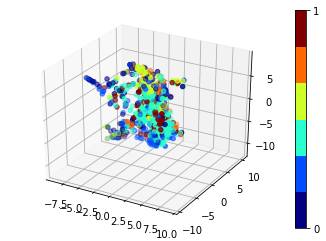

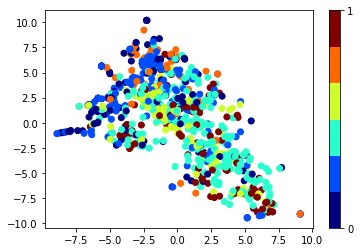

In [8]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


X_embedded = TSNE(n_components=3).fit_transform(training_Xs)

vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]
vis_z = X_embedded[:, 2]

sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap("jet", 6))
sm.set_array([])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vis_x, vis_y, vis_z, c=training_predominant_classes, cmap=plt.cm.get_cmap("jet", 6))
fig.colorbar(sm, ticks=range(6))

fig2 =plt.figure()
bx = fig2.add_subplot(111)
bx.scatter(vis_x, vis_y, c=training_predominant_classes, cmap=plt.cm.get_cmap("jet", 6))
fig2.colorbar(sm, ticks=range(6))

plt.show()

# Neural Network

## Network definition

Reference:  
- What are advantages of Artificial Neural Networks over Support Vector Machines? 
https://stackoverflow.com/questions/11632516/what-are-advantages-of-artificial-neural-networks-over-support-vector-machines

- Keras Guide (contains code and suggestion of any case of use)
https://keras.io/getting-started/sequential-model-guide/

- Number of hidden layers and nodes
https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

### Callbacks
Here we are defining some callbacks that are used during the fitting of the network.  
The first one, is a **custom EarlyStopping callback**, meaning that it will stop the process when
the f1-score of the validation data stops improving. The same callback is also used to collect the history of *f1* and *val_f1* used for the plot.

In [9]:
# util function
def ceil_power_of_2(n):
    """
    Round n to the nearest power of 2
    """
    ex = math.log(n, 2)
    ex = math.ceil(ex)
    return 2**ex


class EarlyStoppingF1Metric(Callback):
    """
    Callback class for Keras
    It is a custom EarlyStopping using sklearn's macro-F1 as metric
    """
    def __init__(self, xs, y, patience=0, min_delta=0, verbose=0, earlystopping=True):
        self.wait = 0
        self.stopped_epoch = 0
        self.monitor_op = np.greater
        self.min_delta = min_delta
        self.patience = patience
        self.best = -np.Inf
        self.verbose = verbose
        self.Xs = xs
        self.y = y
        self.earlystopping = earlystopping
        
    def on_train_begin(self, logs=None):
        self.f1_scores = []
        self.val_f1_scores = []
        
    def on_epoch_end(self, epoch, logs={}):
        # f1
        predict = self.model.predict(self.Xs).round()
        targ = self.y
        f1 = sklearn.metrics.f1_score(predict, targ, average='macro')
        
        # val_f1
        val_predict = self.model.predict(self.validation_data[0]).round()
        val_targ = self.validation_data[1]
        val_f1 = sklearn.metrics.f1_score(val_targ, val_predict, average='macro')
        
        # save results on
        self.f1_scores.append(f1)
        self.val_f1_scores.append(val_f1)
        
        # early stopping on val_f1
        current = val_f1
        
        if self.earlystopping:
            if self.monitor_op(current - self.min_delta, self.best):
                self.best = current
                self.best_epoch = epoch
                self.wait = 0
            else:
                self.wait +=1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                
    def get_history(self):
        history = {}
        history['f1'] = self.f1_scores
        history['val_f1'] = self.val_f1_scores
        return history
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("\n\t\tEpoch %05d: early stopping" % (self.stopped_epoch+1))
            print("\t\tBest Epoch %05d" % (self.best_epoch+1))
            print("\t\tBest Score %f" % (self.best))


# Plot function
def plot_loss_history(filename, history, measure1='loss', measure2='val_loss'):
    plt.figure(figsize=[6,6])
    plt.plot(history[measure1])
    plt.plot(history[measure2])
    plt.title('model ' + measure1  + filename)
    plt.ylabel(measure1)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [10]:
# features array to numpy arrays
x_train = np.array(training_Xs)
x_validation = np.array(validation_Xs)
x_test = np.array(test_Xs)

number_of_output_classes = 6
y_train = keras.utils.to_categorical(training_predominant_classes, number_of_output_classes)
y_test = keras.utils.to_categorical(test_predominant_classes, number_of_output_classes)
y_validation = keras.utils.to_categorical(validation_predominant_classes, number_of_output_classes)

# INFO PURPOSE ONLY
number_of_input_vectors, number_of_input_neurons = x_train.shape
print("number_of_input_vectors", number_of_input_vectors)
print("number_of_input_neurons", number_of_input_neurons)

suggested_number_of_neurons = int((number_of_input_neurons + number_of_output_classes) / 2)
suggested_number_of_neurons = ceil_power_of_2(suggested_number_of_neurons)

print("\nNumber of output classes", number_of_output_classes)
print("Suggested hidden neurons", suggested_number_of_neurons)

number_of_input_vectors 757
number_of_input_neurons 30

Number of output classes 6
Suggested hidden neurons 32


In [11]:
def create_new_model():

    # define a sequential model
    model = Sequential()

    # input
    model.add(Dense(suggested_number_of_neurons, activation='relu', input_dim=number_of_input_neurons))

    # hidden
    model.add(Dense(suggested_number_of_neurons, activation='relu'))
    
    # The output should be one for each class
    model.add(Dense(number_of_output_classes, activation='softmax'))

    # Use Stochastic Gradient Descent as optimization method
    # Keras documentation suggest to do not touch the default
    # parameters excepct the learning rate
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

    # Compile
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    return model

## Evaluation of the test set
#### (with Epoch and Batch size selection)
The following cell is used to determine the best paramaters of *epoch* and *batch_size* to be used during the training of the network. First, we define a list of possible batch sizes, namely *batch_sizes* and then, for each of them we perform 5 times the training and the evaluation of the network using *early-stopping* callback to stop process in order to reduce overfitting.

Early stopping can be configured to use either val_loss or val_f1 score as metrics.
To use val_f1 score, use the custom callback *EarlyStoppingF1Metric* as below.
Use the standard *keras.callbacks.EarlyStopping(monitor='val_loss'...)* for *val_loss*.

The function *test_model* takes:
- b_size= batch_size (integer)
- plot_measure = 'loss' or 'f1' (measure displayed in the plot)
- plot = Boolean (to plot the measures for both training and validation)

Batch size: 32

	Run 0


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



		Epoch 00302: early stopping
		Best Epoch 00202
		Best Score 0.471200

	Run 1

		Epoch 00285: early stopping
		Best Epoch 00185
		Best Score 0.454410

	Run 2

		Epoch 00320: early stopping
		Best Epoch 00220
		Best Score 0.473188

	Run 3

		Epoch 00228: early stopping
		Best Epoch 00128
		Best Score 0.480737


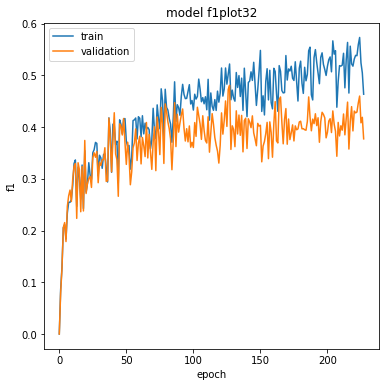


	Run 4

		Epoch 00307: early stopping
		Best Epoch 00207
		Best Score 0.482691
Batch size: 64

	Run 0

		Epoch 00261: early stopping
		Best Epoch 00161
		Best Score 0.489588

	Run 1

		Epoch 00391: early stopping
		Best Epoch 00291
		Best Score 0.462287

	Run 2

		Epoch 00336: early stopping
		Best Epoch 00236
		Best Score 0.469216

	Run 3

		Epoch 00168: early stopping
		Best Epoch 00068
		Best Score 0.468070


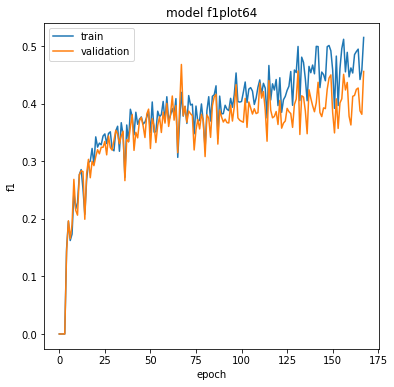


	Run 4

		Epoch 00288: early stopping
		Best Epoch 00188
		Best Score 0.495535
Batch size: 128

	Run 0

		Epoch 00333: early stopping
		Best Epoch 00233
		Best Score 0.458151

	Run 1

		Epoch 00595: early stopping
		Best Epoch 00495
		Best Score 0.491366

	Run 2

		Epoch 00455: early stopping
		Best Epoch 00355
		Best Score 0.471392

	Run 3

		Epoch 00320: early stopping
		Best Epoch 00220
		Best Score 0.472952


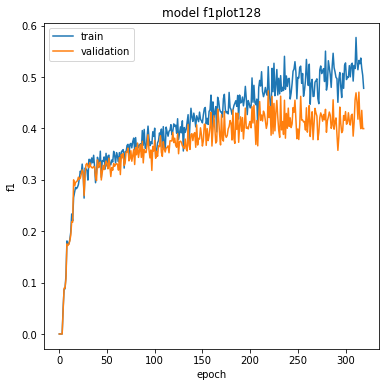


	Run 4

		Epoch 00466: early stopping
		Best Epoch 00366
		Best Score 0.480408
Batch size: 256

	Run 0

		Epoch 00452: early stopping
		Best Epoch 00352
		Best Score 0.448098

	Run 1

		Epoch 00891: early stopping
		Best Epoch 00791
		Best Score 0.483718

	Run 2

		Epoch 00681: early stopping
		Best Epoch 00581
		Best Score 0.445375

	Run 3

		Epoch 00695: early stopping
		Best Epoch 00595
		Best Score 0.465624


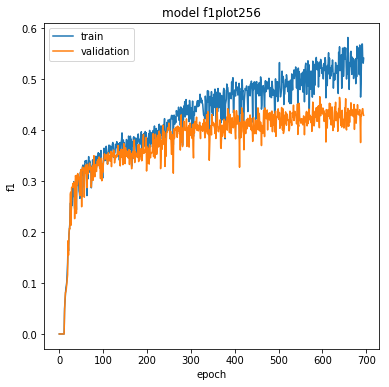


	Run 4

		Epoch 00400: early stopping
		Best Epoch 00300
		Best Score 0.455507
Batch size: 512

	Run 0

		Epoch 00405: early stopping
		Best Epoch 00305
		Best Score 0.418904

	Run 1

		Epoch 00674: early stopping
		Best Epoch 00574
		Best Score 0.456295

	Run 2

		Epoch 00451: early stopping
		Best Epoch 00351
		Best Score 0.433118

	Run 3

		Epoch 00440: early stopping
		Best Epoch 00340
		Best Score 0.426917


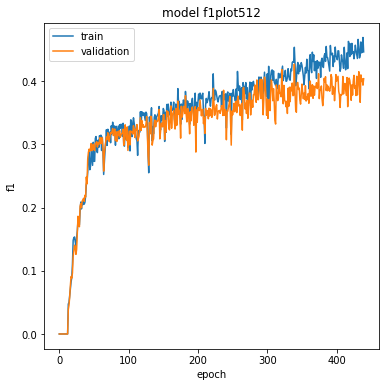


	Run 4

		Epoch 00639: early stopping
		Best Epoch 00539
		Best Score 0.438544
Results:
Best batch_size 64
f1_score_predicted 0.42905049591897393
accuracy_score_predicted 0.47607655502392343


In [12]:
batch_sizes = [32, 64, 128, 256, 512]

best_f1 = - np.Inf
best_size = 0

acc_per_batch_size = []
f1_per_batch_size = []

def test_model(b_size, plot_measure='loss', plot=False):
    """
    batch_size
    """
    model = create_new_model()
    
    model_callbacks = [
        EarlyStoppingF1Metric(x_train, y_train, patience=100, verbose=1, earlystopping=True),
        keras.callbacks.History()
    ]
    
    history = model.fit(
            x_train, y_train,
            validation_data=(x_validation, y_validation),
            callbacks=model_callbacks,
            epochs=10000, # max value of epoch, then, callback will stop it before overfit
            batch_size=b_size,
            verbose=0
            )
    
    # plot 
    if plot:
        if plot_measure == 'loss':
            plot_loss_history("plot" + str(batch_sizes[i]), history.history)
        else:            
            if not isinstance(model_callbacks[0], EarlyStoppingF1Metric):
                print("cannot plot f1 scores if early stopping method is not a EarlyStoppingF1Metric instance")
                return
            
            f1_history = model_callbacks[0].get_history()
            plot_loss_history("plot" + str(batch_sizes[i]), f1_history, measure1='f1', measure2='val_f1')
        
    y_predicted = model.predict(x_test, batch_size=batch_sizes[i]).round()
    f1_score_predicted = sklearn.metrics.f1_score(y_predicted, y_test, average='macro')
    accuracy_predicted = sklearn.metrics.accuracy_score(y_predicted, y_test)
    
    return f1_score_predicted, accuracy_predicted
        
    
# Get best batch_size
for i, _ in enumerate(batch_sizes):
    # For each batch size in batch_sizes

    # Run the same test 5 times and save results in temp lists
    best_f1_scores = []
    best_acc_scores = []
    
    print("Batch size:", batch_sizes[i])
    
    for j in range(5):
        print("\n\tRun", j)
        # One plot per graph --> (j == 3)
        f1_score_predicted, accuracy_predicted = test_model(batch_sizes[i], plot_measure='f1', plot=(j == 3))
        best_f1_scores.append(f1_score_predicted)
        best_acc_scores.append(accuracy_predicted)

    # current is the mean of the 5 f1 scores
    current = np.mean(best_f1_scores)
    
    # append the mean of the results into global lists
    f1_per_batch_size.append(current)
    acc_per_batch_size.append(np.mean(accuracy_predicted))
    
    # check if a new record was reached
    if current > best_f1:
        best_f1 = current
        best_size = i
        
print("========")
print("Results:")
print("Best batch_size", batch_sizes[best_size])
print("f1_score_predicted", f1_per_batch_size[best_size])
print("accuracy_score_predicted", acc_per_batch_size[best_size])